# 01 - Baseline CNN on FashionMNIST

**Goal**: Train a baseline CNN and evaluate clean accuracy before adversarial attacks.

This notebook establishes our baseline model performance.

In [1]:
# Colab setup: mount drive and install dependencies if needed
import sys
import os

# Add src to path for imports
if 'google.colab' in sys.modules:
    # Running in Colab
    %cd /content
    !git clone https://github.com/cdm34/adversarial-robustness.git 2>/dev/null || true
    %cd adversarial-robustness
    sys.path.insert(0, '/content/adversarial-robustness')
else:
    # Running locally
    sys.path.insert(0, os.path.abspath('..'))

/content
/content/adversarial-robustness


In [2]:
import torch
import matplotlib.pyplot as plt

from src import (
    FashionMNISTNet,
    DataConfig, get_fashion_mnist_datasets, split_train_val, make_loaders,
    TrainConfig, fit,
    accuracy, per_class_accuracy, confidence_stats,
    get_device, set_seed,
    plot_training_curves, save_figure,
    FASHION_MNIST_CLASSES,
)

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cu126


# Optional Google Drive mounting

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Use Drive for checkpoints
import os
CHECKPOINT_DIR = '/content/drive/MyDrive/adversarial-robustness-checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Mounted at /content/drive


## 1. Setup

In [4]:
# Reproducibility
set_seed(42)

# Device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## 2. Load Data

In [5]:
# Load FashionMNIST
train_ds, test_ds = get_fashion_mnist_datasets()
print(f"Training samples: {len(train_ds)}")
print(f"Test samples: {len(test_ds)}")

# Split train/val
data_cfg = DataConfig(batch_size=128, val_ratio=0.1, num_workers=2)
train_subset, val_subset = split_train_val(train_ds, data_cfg.val_ratio, data_cfg.seed)

# Create loaders
train_loader, val_loader, test_loader = make_loaders(
    train_subset, val_subset, test_ds, data_cfg, device
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.82MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.5MB/s]

Training samples: 60000
Test samples: 10000
Train batches: 422, Val batches: 47, Test batches: 79


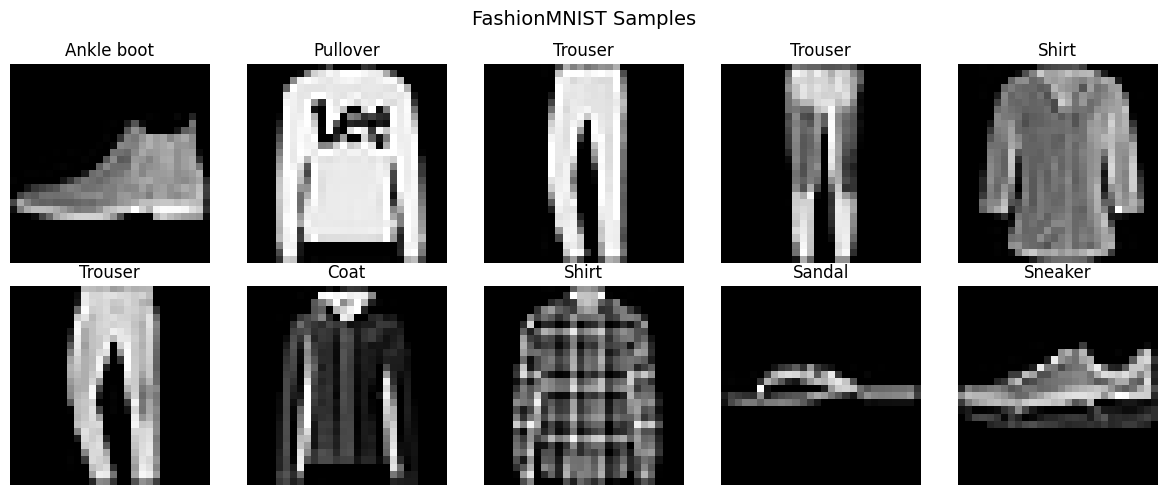

In [6]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
x_sample, y_sample = next(iter(test_loader))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_sample[i].squeeze(), cmap='gray')
    ax.set_title(FASHION_MNIST_CLASSES[y_sample[i]])
    ax.axis('off')

plt.suptitle('FashionMNIST Samples', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Train Baseline CNN

In [7]:
# Instantiate model
model = FashionMNISTNet().to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

FashionMNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 352,330


In [8]:
# Training config
train_cfg = TrainConfig(epochs=10, lr=1e-3, optimizer='adam')

# Train
print("Training baseline CNN...")
result = fit(model, train_loader, val_loader, device, train_cfg)

print(f"\nBest validation accuracy: {result['best_val_acc']:.2f}%")

Training baseline CNN...

Best validation accuracy: 91.70%


Saved: reports/figures/baseline_training_curves.png


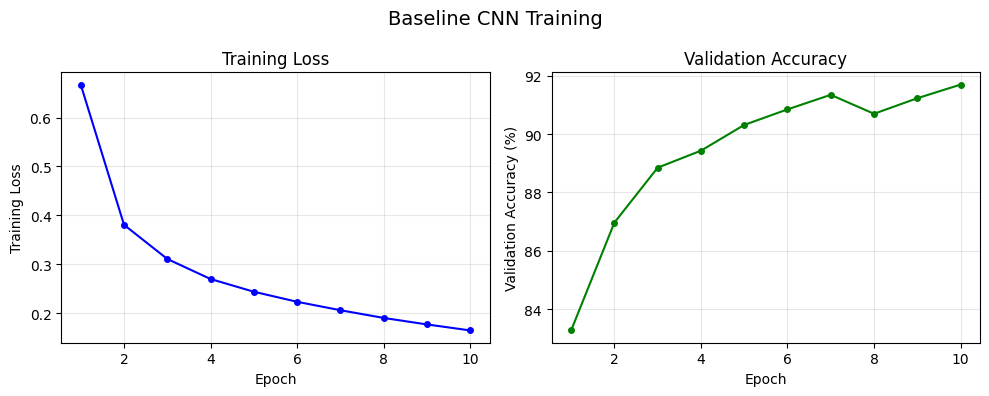

In [9]:
# Plot training curves
fig = plot_training_curves(result['history'], title='Baseline CNN Training')
save_figure(fig, 'baseline_training_curves')
plt.show()

## 4. Evaluate on Test Set

In [10]:
# Clean test accuracy
test_acc = accuracy(model, test_loader, device)
print(f"Clean Test Accuracy: {test_acc:.2f}%")

Clean Test Accuracy: 91.04%


In [11]:
# Per-class accuracy (identify failure modes)
class_results = per_class_accuracy(model, test_loader, device)

print("\nPer-Class Accuracy:")
for i, acc in enumerate(class_results['per_class_accuracy']):
    print(f"  {FASHION_MNIST_CLASSES[i]:12s}: {acc:.1f}%")

print(f"\nWorst class: {FASHION_MNIST_CLASSES[class_results['worst_class']]}")
print(f"Best class:  {FASHION_MNIST_CLASSES[class_results['best_class']]}")


Per-Class Accuracy:
  T-shirt/top : 80.0%
  Trouser     : 98.8%
  Pullover    : 89.0%
  Dress       : 95.4%
  Coat        : 79.0%
  Sandal      : 94.2%
  Shirt       : 80.5%
  Sneaker     : 98.3%
  Bag         : 98.5%
  Ankle boot  : 96.7%

Worst class: Coat
Best class:  Trouser


In [12]:
# Confidence statistics (AI safety metric)
conf_stats = confidence_stats(model, test_loader, device)

print("\nConfidence Statistics:")
print(f"  Mean confidence: {conf_stats['mean_confidence']:.3f}")
print(f"  Std confidence:  {conf_stats['std_confidence']:.3f}")
print(f"  Min confidence:  {conf_stats['min_confidence']:.3f}")
print(f"  Max confidence:  {conf_stats['max_confidence']:.3f}")


Confidence Statistics:
  Mean confidence: 0.937
  Std confidence:  0.127
  Min confidence:  0.229
  Max confidence:  1.000


/tmp/ipython-input-740781885.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(FASHION_MNIST_CLASSES, rotation=45, ha='right')


Saved: reports/figures/baseline_per_class_accuracy.png


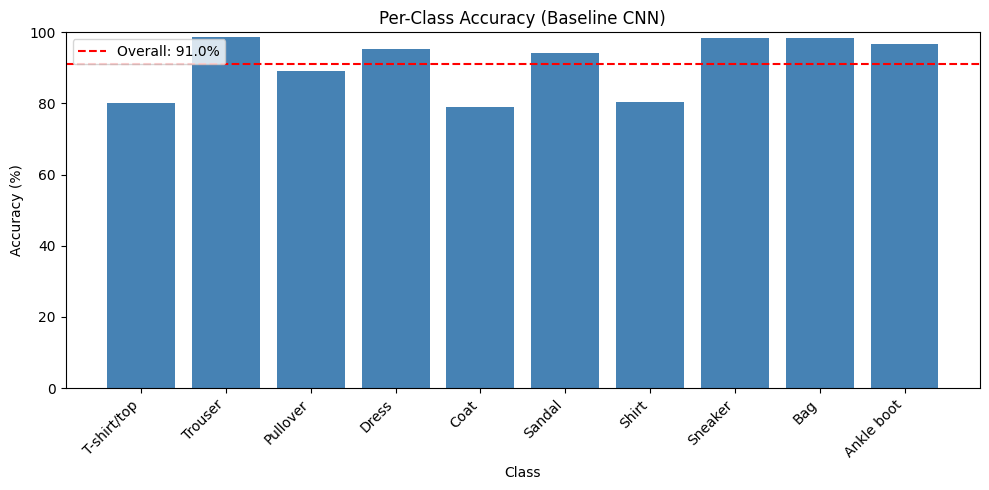

In [13]:
# Per-class accuracy bar chart
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(FASHION_MNIST_CLASSES, class_results['per_class_accuracy'], color='steelblue')
ax.axhline(y=test_acc, color='red', linestyle='--', label=f'Overall: {test_acc:.1f}%')
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Per-Class Accuracy (Baseline CNN)')
ax.set_xticklabels(FASHION_MNIST_CLASSES, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 100)
plt.tight_layout()
save_figure(fig, 'baseline_per_class_accuracy')
plt.show()

## 5. Save Model Checkpoint

In [14]:
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies
}, f'{CHECKPOINT_DIR}/baseline_cnn.pt')

Model saved to checkpoints/baseline_cnn.pt


## Summary

- Trained baseline CNN on FashionMNIST
- Clean test accuracy: TBD
- Identified difficult classes (e.g., Shirt vs. T-shirt/top)
- Model shows high confidence on test samples

**Next**: Evaluate vulnerability to adversarial attacks (FGSM, PGD)